In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import tree
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, roc_auc_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.feature_selection import f_regression
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
import pickle

In [2]:
csv_files = glob.glob("./*.csv")

In [3]:
csv_files

['.\\AUD_USD_H1.csv',
 '.\\EUR_GBP_H1.csv',
 '.\\EUR_USD_H1.csv',
 '.\\GBP_USD_H1.csv',
 '.\\USD_CAD_H1.csv',
 '.\\USD_CHF_H1.csv',
 '.\\USD_JPY_H1.csv']

In [4]:
dataframes = {} # Crear dict vacío
keys_list = []  # Crear lista vacía

for file in csv_files:
    key = file.split(".\\")[1]
    key = key.replace("_H1.csv", "")  # Eliminar ".csv" del final de la clave
    dataframes[key] = pd.read_csv(file)
    keys_list.append(key)  # Agregar key a la lista

print(keys_list)

['AUD_USD', 'EUR_GBP', 'EUR_USD', 'GBP_USD', 'USD_CAD', 'USD_CHF', 'USD_JPY']


In [5]:
for key in dataframes:
    print(key, dataframes[key].shape)

AUD_USD (50000, 9)
EUR_GBP (50000, 9)
EUR_USD (50000, 9)
GBP_USD (50000, 9)
USD_CAD (50000, 9)
USD_CHF (50000, 9)
USD_JPY (50000, 9)


In [6]:
dataframes

{'AUD_USD':                    time  open_bid  high_bid  low_bid  close_bid  open_ask  \
 0      2015-01-27 08 PM   0.79375   0.79524  0.79347    0.79383   0.79393   
 1      2015-01-27 09 PM   0.79382   0.79382  0.79265    0.79344   0.79405   
 2      2015-01-27 10 PM   0.79338   0.79364  0.79243    0.79250   0.79385   
 3      2015-01-27 11 PM   0.79256   0.79304  0.79184    0.79197   0.79290   
 4            2015-01-28   0.79197   0.80024  0.78991    0.79930   0.79216   
 ...                 ...       ...       ...      ...        ...       ...   
 49995  2023-02-09 09 PM   0.69321   0.69356  0.69317    0.69354   0.69334   
 49996  2023-02-09 10 PM   0.69339   0.69377  0.69299    0.69348   0.69385   
 49997  2023-02-09 11 PM   0.69346   0.69423  0.69339    0.69378   0.69393   
 49998        2023-02-10   0.69379   0.69423  0.69299    0.69419   0.69394   
 49999  2023-02-10 01 AM   0.69419   0.69452  0.69388    0.69445   0.69432   
 
        high_ask  low_ask  close_ask  
 0       0.7

In [7]:
concatenated_df = pd.concat(dataframes.values(), axis=1)

In [8]:
opens = concatenated_df['open_bid']
opens.columns = keys_list

In [9]:
opens

,AUD_USD,EUR_GBP,EUR_USD,GBP_USD,USD_CAD,USD_CHF,USD_JPY
0,0.79375,0.74758,1.13343,1.51644,1.25236,0.90455,117.668
1,0.79382,0.74725,1.13335,1.51671,1.25267,0.90435,117.679
2,0.79338,0.74764,1.13399,1.51812,1.25281,0.90724,117.447
3,0.79256,0.74743,1.13358,1.51600,1.25375,0.90299,117.507
4,0.79197,0.74852,1.13544,1.51859,1.25192,0.90129,117.469
...,...,...,...,...,...,...,...
49995,0.69321,0.88578,1.07328,1.21158,1.34602,0.92268,131.613
49996,0.69339,0.88509,1.07345,1.21147,1.34470,0.92169,131.549
49997,0.69346,0.88562,1.07392,1.21173,1.34482,0.92184,131.420
49998,0.69379,0.88628,1.07385,1.21145,1.34477,0.92205,131.509


In [10]:
returns = np.log(opens/opens.shift(1))

# Descartar la primera fila (que contiene valores NaN debido al desplazamiento)
returns = returns.iloc[1:]

# Mostrar los retornos
returns

,AUD_USD,EUR_GBP,EUR_USD,GBP_USD,USD_CAD,USD_CHF,USD_JPY
1,0.000088,-0.000442,-0.000071,0.000178,0.000248,-0.000221,0.000093
2,-0.000554,0.000522,0.000565,0.000929,0.000112,0.003191,-0.001973
3,-0.001034,-0.000281,-0.000362,-0.001397,0.000750,-0.004696,0.000511
4,-0.000745,0.001457,0.001639,0.001707,-0.001461,-0.001884,-0.000323
5,0.009138,0.000401,0.001294,0.000375,0.000926,-0.001699,0.000987
...,...,...,...,...,...,...,...
49995,-0.000980,-0.000248,-0.000373,-0.000140,0.000713,0.000434,0.000350
49996,0.000260,-0.000779,0.000158,-0.000091,-0.000981,-0.001074,-0.000486
49997,0.000101,0.000599,0.000438,0.000215,0.000089,0.000163,-0.000981
49998,0.000476,0.000745,-0.000065,-0.000231,-0.000037,0.000228,0.000677


In [11]:
returns.to_csv('returns.csv')

### Consideremos la matriz de correlacion para las features y la target

In [12]:
corr_matrix = returns.corr().abs()

corr_matrix

,AUD_USD,EUR_GBP,EUR_USD,GBP_USD,USD_CAD,USD_CHF,USD_JPY
AUD_USD,1.000000,0.023534,0.114771,0.140486,0.095499,0.081279,0.091711
EUR_GBP,0.023534,1.000000,0.242374,0.075940,0.023559,0.013573,0.020492
EUR_USD,0.114771,0.242374,1.000000,0.180636,0.072282,0.108194,0.130609
GBP_USD,0.140486,0.075940,0.180636,1.000000,0.092200,0.115196,0.104549
USD_CAD,0.095499,0.023559,0.072282,0.092200,1.000000,0.084583,0.068163
USD_CHF,0.081279,0.013573,0.108194,0.115196,0.084583,1.000000,0.096968
USD_JPY,0.091711,0.020492,0.130609,0.104549,0.068163,0.096968,1.000000


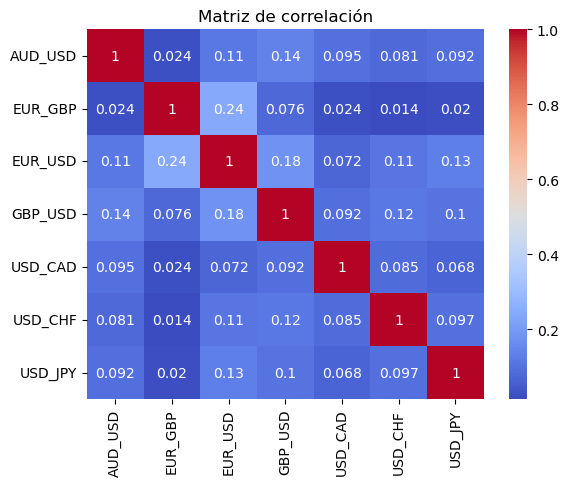

In [13]:
# Gráfica de la matríz de correlación

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

In [14]:
# Seleccionemos la mejor columna a predecir

best_column = corr_matrix.iloc[:-1, -1].idxmax()

print("La mejor columna para predecir es:", best_column)

La mejor columna para predecir es: EUR_USD


In [15]:
# Definir las variables independientes (predictoras) y la variable dependiente (objetivo)

X = returns.drop(best_column, axis=1)
y = returns[best_column]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
# Implementando la técnica de regresión lineal más conocida (OLS), mínimos cuadrados ordinarios:

X = sm.add_constant(X)
    
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                EUR_USD   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1207.
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:14:20   Log-Likelihood:             2.7405e+05
No. Observations:               49999   AIC:                        -5.481e+05
Df Residuals:                   49992   BIC:                        -5.480e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.544e-07   4.51e-06     -0.190      0.8

###### - El valor de R-cuadrado es 0.127, lo que significa que el modelo explica el 12.7% de la variabilidad de los datos.

###### - El p-valor en este caso, todos los coeficientes tienen un p-valor menor que 0.05, lo que indica que son estadísticamente significativos.


In [17]:
# Ahora aplicando el modelo de regresión lineal múltiple en el conjunto de entrenamiento:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predecir los valores del conjunto de prueba
y_pred = regressor.predict(X_test)

# imprimimos los coeficientes del modelo y el intercepto
print('Coeficientes:', regressor.coef_)
print('Intercepto:', regressor.intercept_)

Coeficientes: [ 0.06372376  0.24606895  0.13893988 -0.05604398 -0.07642807 -0.09962549]
Intercepto: -3.921666003094603e-06


In [18]:
# Calcular las métricas de rendimiento del modelo en el conjunto de prueba
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"El error cudrático medio R^2 es: {r2:.3F}")
print(f"La raíz cuadrada del R2 (MSE) es: {mse:.3F}")
print(f"El error absoluto medio (MAE) es: {mae:.4F}")

El error cudrático medio R^2 es: 0.121
La raíz cuadrada del R2 (MSE) es: 0.001
El error absoluto medio (MAE) es: 0.0007


El valor de R2 es 0.121, lo que indica que el modelo explica solo el 12.1% de la varianza en los datos de prueba. Este valor no es muy alto y sugiere que el modelo no es muy efectivo en la predicción de los valores de la variable dependiente.

El valor de MSE es 0.001, lo que indica que el modelo tiene una precisión razonable en la predicción de los valores de la variable dependiente.

El valor de MAE es 0.0007, lo que indica que el modelo tiene una precisión razonable en la predicción de los valores de la variable dependiente.

En general, aunque el modelo tiene una precisión razonable en la predicción de los valores de la variable dependiente (como se indica por los valores bajos de MSE y MAE), el bajo valor de R2 sugiere que el modelo no es muy efectivo en la explicación de la varianza en los datos de prueba.

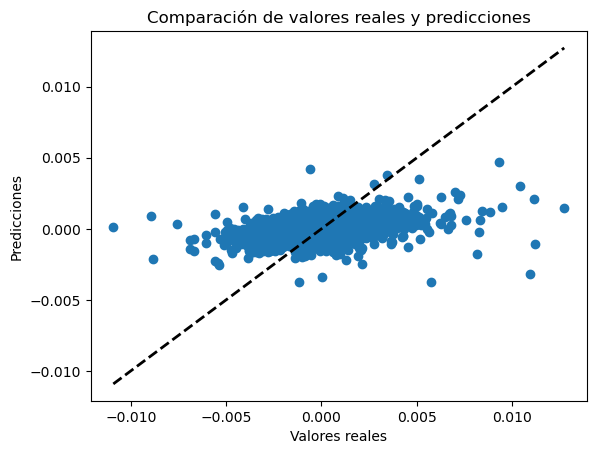

In [19]:
# Visualizar las predicciones del modelo en comparación con los valores reales
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales y predicciones')
plt.show()

###### El modelo no ha hecho buenas predicciones. Los puntos están dispersos, esto sugiere que el modelo no ha sido capaz de capturar adecuadamente la relación entre las variables de entrada y la variable de salida.

##### Implementando Pipeline

In [20]:
# Pipeline + GridSearch

# Definir los preprocesadores y el modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Definir los hiperparámetros para GridSearch
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [None, 5, 10],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X, y)

# Imprimir los mejores hiperparámetros y score de validación cruzada
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor score de validación cruzada:", grid_search.best_score_)

# Predecir el resultado para los datos de prueba y calcular métricas de evaluación
y_pred = grid_search.predict(X)
print("R2 score:", r2_score(y, y_pred))
print("Mean absolute error:", mean_absolute_error(y, y_pred))

c:\Users\ana mario\anaconda3\envs\DH\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\ana mario\anaconda3\envs\DH\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\ana mario\anaconda3\envs\DH\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also

Mejores hiperparámetros encontrados: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 10}
Mejor score de validación cruzada: 0.0065307216561858675
R2 score: 0.1523758169280558
Mean absolute error: 0.0006487297120018296


###### - La primera línea define el modelo de regresión como una tubería (pipeline) que aplica una escala de características estándar (StandardScaler()) y luego entrena un modelo de bosques aleatorios (RandomForestRegressor()).
###### - La segunda línea define una cuadrícula de hiperparámetros para la búsqueda, donde se especifican las opciones para el número de árboles (n_estimators), la profundidad máxima del árbol (max_depth) y el número máximo de características consideradas para cada división (max_features).
###### - La tercera línea realiza la búsqueda de hiperparámetros utilizando validación cruzada de 5 pliegues (cv=5).
###### - Las dos líneas siguientes imprimen los mejores hiperparámetros encontrados y el puntaje (score) de validación cruzada correspondiente. El mejor puntaje de validación cruzada se refiere al promedio del rendimiento del modelo en los diferentes pliegues de validación cruzada.
###### - Las últimas tres líneas utilizan el modelo entrenado con los mejores hiperparámetros encontrados para hacer predicciones sobre el conjunto de datos de entrenamiento X. Luego se imprimen dos métricas de evaluación del rendimiento del modelo: el coeficiente de determinación R cuadrado (r2_score) y el error absoluto medio (mean_absolute_error).
###### Los resultados de la búsqueda de hiperparámetros indican que el mejor conjunto de hiperparámetros encontrado incluye 10 árboles, una profundidad máxima de 5 y el número máximo de características por división de sqrt (raíz cuadrada). Además, el puntaje de validación cruzada obtenido es muy bajo, lo que sugiere que el modelo no es muy bueno en general para predecir los valores objetivo. Las métricas de evaluación indican un bajo rendimiento del modelo en el conjunto de entrenamiento, con un valor de R cuadrado de 0.15 y un error absoluto medio muy bajo.

In [21]:
with open ('regressor.pkl', 'wb') as f: 

    pickle.dump(regressor, f)

In [22]:
with open ('grid_search.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

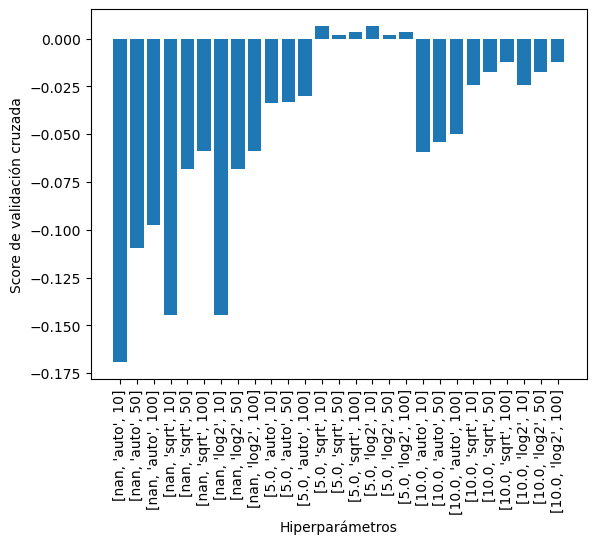

In [23]:
# Graficar 

# Esto creará un gráfico de barras con las etiquetas de las combinaciones de hiperparámetros en el eje x en 
# lugar de los diccionarios de parámetros originales.


# Extraer los resultados de la búsqueda de hiperparámetros
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

# Convertir la lista de diccionarios en un DataFrame de pandas
df = pd.DataFrame(params)

# Extraer solo los valores de los hiperparámetros
df = df.applymap(lambda x: x if isinstance(x, str) else list(x.values())[0] if isinstance(x, dict) else x)


# Crear un gráfico de barras con los resultados
fig, ax = plt.subplots()
ax.bar(range(len(params)), mean_scores)
ax.set_xticks(range(len(params)))
ax.set_xticklabels(df.values.tolist(), rotation=90)
ax.set_xlabel('Hiperparámetros')
ax.set_ylabel('Score de validación cruzada')
plt.show()



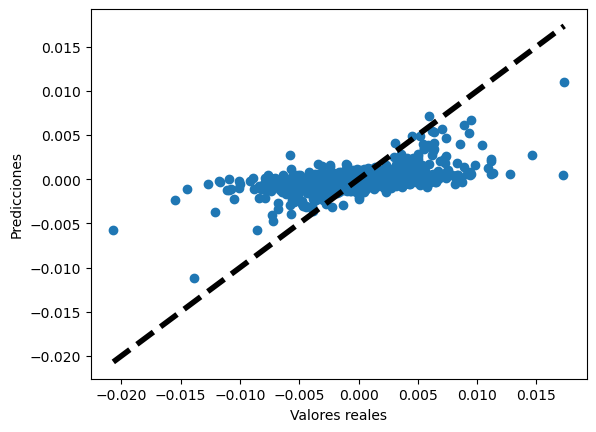

In [24]:
fig, ax = plt.subplots()
ax.scatter(y, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Valores reales')
ax.set_ylabel('Predicciones')
plt.show()

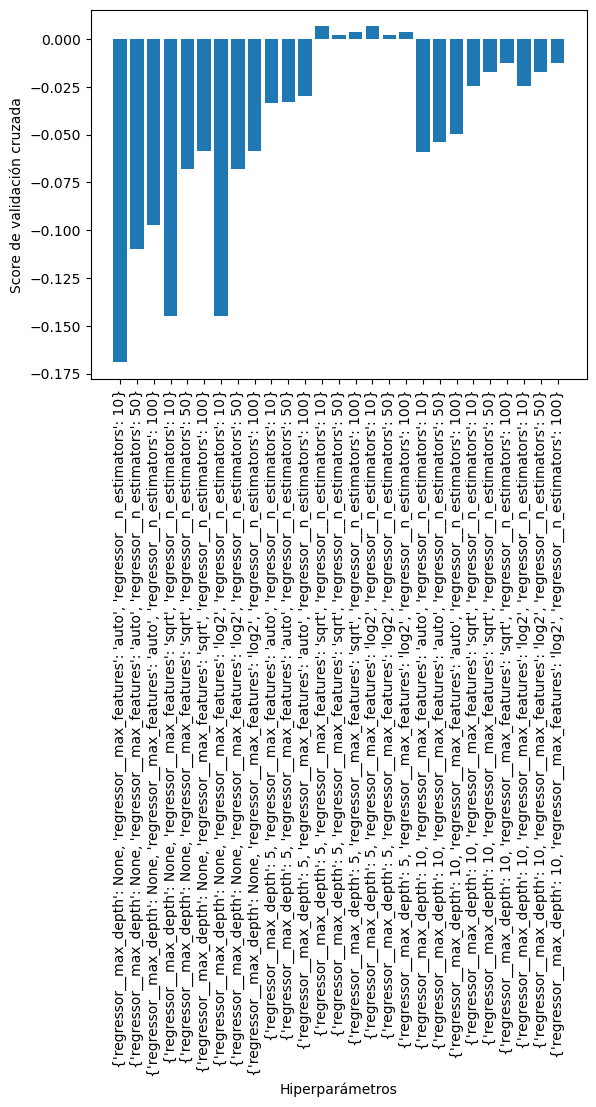

In [25]:
# Gráfico

# Extraer los resultados de la búsqueda de hiperparámetros
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

# Crear un gráfico de barras con los resultados
fig, ax = plt.subplots()
ax.bar(range(len(params)), mean_scores)
ax.set_xticks(range(len(params)))
ax.set_xticklabels(params, rotation=90)
ax.set_xlabel('Hiperparámetros')
ax.set_ylabel('Score de validación cruzada')
plt.show()